### Debug OCR using a single line image

In [35]:
import cv2
import json
import pyewts
import numpy as np
import tensorflow as tf
import onnxruntime as ort
import matplotlib.pyplot as plt
from Utils import prepare_ocr_image, pad_image2
from fast_ctc_decode import viterbi_search, beam_search
from IPython.display import Image as ShowImage

ModuleNotFoundError: No module named 'pyewts'

In [27]:
def get_model_characters(characters: str):
    characters = [c for c in characters]
    characters.append("[BLK]")
    characters.insert(0, "[UNK]")

    return characters

def show_line(image: np.array, swap_dims: bool = False) -> None:
    if swap_dims:
        image = np.transpose(image, axes=[1, 0])
    plt.figure(figsize=(20, 8))
    plt.axis("off")
    plt.imshow(image)
    

def preprocess_image_tf(image: np.array, target_height: int = 80, target_width: int = 2000):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=0.8, tileGridSize=(24,24))
    image = clahe.apply(image)
    image = tf.expand_dims(image, axis=-1)
    image = tf.image.resize_with_pad(image, target_height, target_width)
    image = image / 255.0
    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.squeeze(image)
    
    return image.numpy()


def preprocess_image_np(
    image: np.array,
    target_width: int = 2000,
    target_height: int = 80,
    padding: str = "black",
):
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=0.8, tileGridSize=(24,24))
    image = clahe.apply(image)
    image = pad_image2(image, target_width, target_height, padding=padding)
    image = image.astype(np.float32)
    image /= 255.0
    image = np.transpose(image, axes=[1, 0])

    return image

In [15]:
ocr_model_config = "Models/OCRModels/LhasaKanjur/model_config.json"
json_file = open(ocr_model_config, encoding="utf-8")
json_content = json.loads(json_file.read())
onnx_model_file = json_content["model"]
input_width = json_content["input_width"]
nput_height = json_content["input_height"]
ocr_charset = get_model_characters(json_content["charset"])
ocr_session = ort.InferenceSession(onnx_model_file, providers=["CPUExecutionProvider"])

In [16]:
image = cv2.imread("Data\LhasaKankur_testline.jpg")

tf_image = preprocess_image_tf(image)
np_image = preprocess_image_np(image)

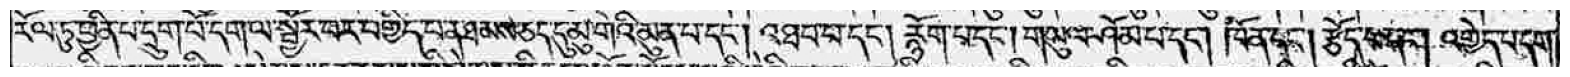

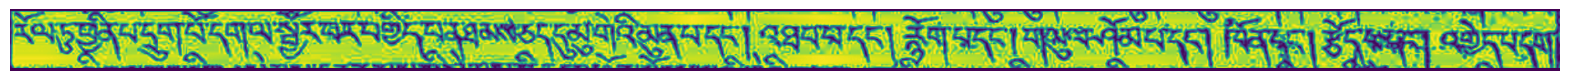

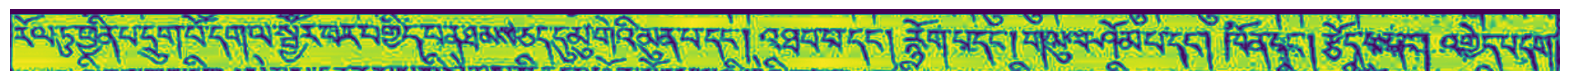

In [33]:
show_line(image)
show_line(tf_image, swap_dims=True)
show_line(np_image, swap_dims=True)

#### Compare ONNX Predictions

In [34]:
np_img_batch = np.array([np_image])
ort_batch = ort.OrtValue.ortvalue_from_numpy(np_img_batch)
ocr_results = ocr_session.run_with_ort_values(
    ["Final"], {"the_input": ort_batch}
)
onnx_prediction = ocr_results[0].numpy()
onnx_prediction = onnx_prediction[0, :, :]

text, _ = viterbi_search(onnx_prediction, ocr_charset)
text = text.replace("[BLK]", "")
print(text)

rol tu phyin pa drug pa dag la sbyor bar bgyid pa na thams cad du mu ga'i mun pa dang / 'thrub pa dang / rog pa dng / gsung nshom spaldag bad dad sgyun 
